<a href="https://colab.research.google.com/github/Soares-remootFR/churn_prediction/blob/main/RID85524_Desafio06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Desafio: Prevendo Usuários com Alta Chance de Churn**

---

## Modelo De Classificação (Churn)

### Você trabalha em uma plataforma de streaming e a diretoria está preocupada com o alto índice de usuários cancelando as suas assinaturas. Eles acreditam que é possível prever se um usuário tem mais chance de deixar a plataforma antes que isso aconteça, e com base nessa informação tomar ações para reduzir o churn.

### Seu objetivo é criar um modelo de classificação capaz de prever se um usuário tem mais chance de cancelar a sua assinatura na plataforma ou não. Para isso, a empresa forneceu uma base de dados em csv contendo dados sobre as contas dos clientes.

##Bibliotecas

In [1]:
# Importando bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

##Carregando a Base de Dados

In [2]:
# Carregando os dados
df = pd.read_csv('streaming_data.csv')

## 1. Análise Explratória

In [3]:
# Exibindo informações gerais
print("Informações do dataset:")
print(df.info())

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB
None


In [4]:
# Descrição estatística
print("\nDescrição estatística:")
print(df.describe())


Descrição estatística:
                Age  Time_on_platform  Devices_connected  \
count  66607.000000      56464.000000       52696.000000   
mean      43.511072       4385.848505           2.995370   
std       15.043158       2526.580859           1.414072   
min       18.000000          0.000000           1.000000   
25%       30.000000       2196.000000           2.000000   
50%       43.000000       4384.000000           3.000000   
75%       57.000000       6573.000000           4.000000   
max       69.000000       8759.000000           5.000000   

       Num_streaming_services  Num_active_profiles    Avg_rating       Churned  
count             9572.000000         77884.000000  60614.000000  61148.000000  
mean                 2.496239             3.002273      3.002252      0.243066  
std                  1.120700             1.413235      1.154963      0.428938  
min                  1.000000             1.000000      1.000000      0.000000  
25%                  1.000000 

In [5]:
# Verificando valores ausentes
print("\nValores ausentes por coluna:")
print(df.isna().sum())


Valores ausentes por coluna:
Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64


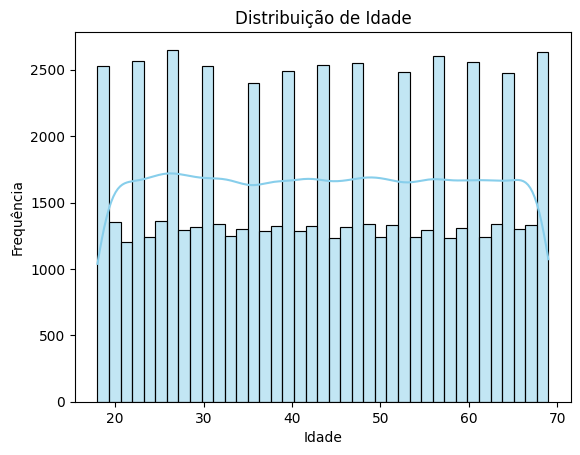

In [6]:
# Plotagens para entender a distribuição dos dados
sns.histplot(df['Age'], kde=True, color='skyblue')
plt.title('Distribuição de Idade')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show();

<ipython-input-7-dc010ee11238>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churned', palette='pastel')


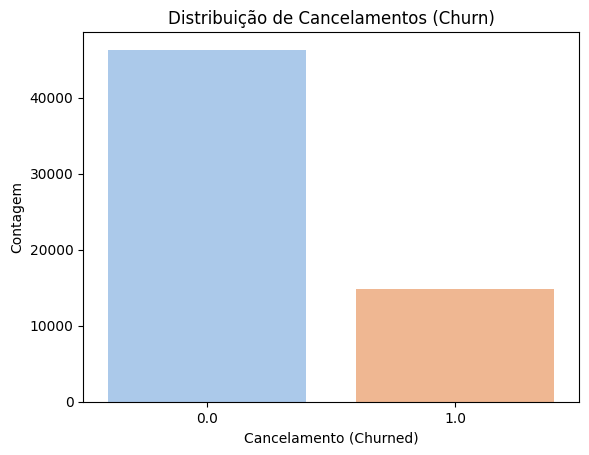

In [7]:
sns.countplot(data=df, x='Churned', palette='pastel')
plt.title('Distribuição de Cancelamentos (Churn)')
plt.xlabel('Cancelamento (Churned)')
plt.ylabel('Contagem')
plt.show();

##02. Tratamento dos Dados (Data Preparation)

In [8]:
# Substituindo valores NaN nas colunas específicas
cols_to_fill = ['Time_on_platform', 'Num_streaming_services', 'Churned', 'Avg_rating', 'Devices_connected']
df[cols_to_fill] = df[cols_to_fill].fillna(0)

In [9]:
# Removendo linhas nulas em colunas essenciais
df.dropna(subset=['Gender', 'Subscription_type', 'Age'], inplace=True)

In [10]:
# Transformando a coluna 'Churned' para valores categóricos 'No' e 'Yes'
df['Churned'] = df['Churned'].replace({0: 'No', 1: 'Yes'})

In [11]:
# Convertendo valores float em inteiros
cols_to_int = ['Time_on_platform', 'Devices_connected', 'Num_streaming_services', 'Num_active_profiles', 'Avg_rating']
df[cols_to_int] = df[cols_to_int].astype(int)

##3. Modelagem de Dados - Regressão Logística

In [12]:
# Pré-processamento de variáveis categóricas com LabelEncoder
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Subscription_type'] = label_encoder.fit_transform(df['Subscription_type'])

In [13]:
# Normalizando variáveis numéricas
scaler = MinMaxScaler()
num_cols = ['Age', 'Time_on_platform', 'Devices_connected', 'Num_streaming_services', 'Num_active_profiles', 'Avg_rating']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [14]:
# Definindo X (variáveis independentes) e y (variável dependente)
X = df.drop(columns=['User_id', 'Churned'])
y = label_encoder.fit_transform(df['Churned'])

In [15]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
# Criando e treinando o modelo de Regressão Logística
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression()

In [17]:
# Realizando predições com o modelo treinado
y_pred_log = log_model.predict(X_test)

In [18]:
# Adicionando as previsões ao DataFrame de teste
df_test = X_test.copy()
df_test = df_test.assign(Predicted_Churn=y_pred_log)


--- Resultados Regressão Logística ---


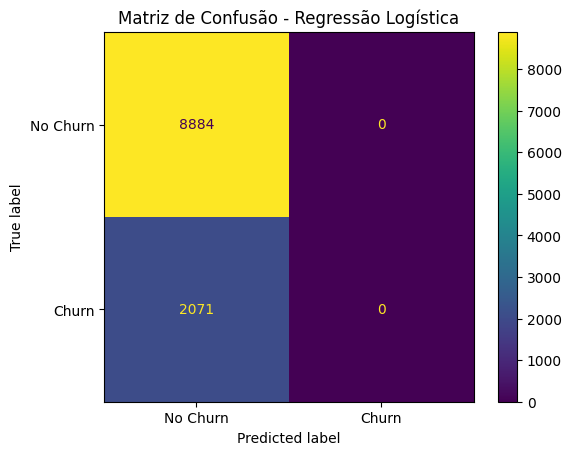

              precision    recall  f1-score   support

           0       0.81      1.00      0.90      8884
           1       0.00      0.00      0.00      2071

    accuracy                           0.81     10955
   macro avg       0.41      0.50      0.45     10955
weighted avg       0.66      0.81      0.73     10955



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
# Avaliando o modelo de Regressão Logística
print("\n--- Resultados Regressão Logística ---")
cm_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cm_log, display_labels=['No Churn', 'Churn']).plot()
plt.title('Matriz de Confusão - Regressão Logística')
plt.show();

print(classification_report(y_test, y_pred_log))

##4. Modelo 1 - Regressão Logística

In [20]:
# Criando um modelo de Regressão Logística
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [21]:
# Melhor modelo obtido pelo Grid Search
best_rf_model = grid_search.best_estimator_
print("\nMelhores parâmetros do modelo Random Forest:")
print(grid_search.best_params_)


Melhores parâmetros do modelo Random Forest:
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [22]:
# Realizando predições com o melhor modelo Random Forest
y_pred_rf = best_rf_model.predict(X_test)

##5. Modelo 2 - Random Forest


--- Resultados Random Forest ---


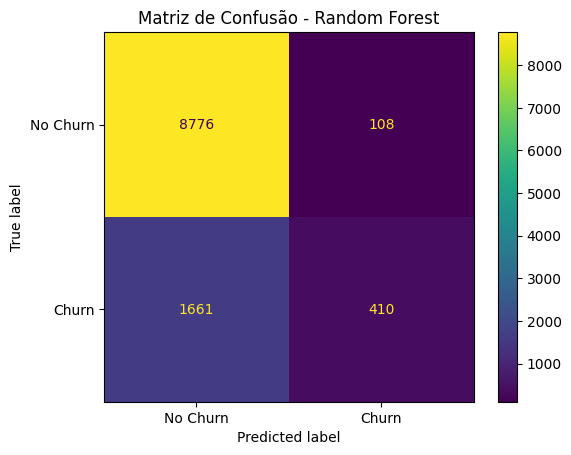

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      8884
           1       0.79      0.20      0.32      2071

    accuracy                           0.84     10955
   macro avg       0.82      0.59      0.61     10955
weighted avg       0.83      0.84      0.80     10955



In [23]:
# Avaliando o modelo de Random Forest
print("\n--- Resultados Random Forest ---")
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf, display_labels=['No Churn', 'Churn']).plot()
plt.title('Matriz de Confusão - Random Forest')
plt.show();

print(classification_report(y_test, y_pred_rf))